In [1]:
from matplotlib import pyplot as plt
from nettack_0 import utils, GCN
from nettack_0 import nettack as ntk
import numpy as np

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tia

In [2]:
# set this to your desired GPU ID if you want to use GPU computations (only for the GCN/surrogate training)
gpu_id = None

In [3]:
### Load network, basic setup
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora.npz')
#adj_matrix, attr_matrix, labels
_A_obs = _A_obs + _A_obs.T#because direct graph
_A_obs[_A_obs > 1] = 1#
lcc = utils.largest_connected_components(_A_obs)# Subgraph of the input graph where only the nodes in largest n_components are kept.
_A_obs = _A_obs[lcc][:,lcc]# 取lcc行的lcc列数据

assert np.abs(_A_obs - _A_obs.T).sum() == 0, "Input graph is not symmetric"#if boolen==True, continue
assert _A_obs.max() == 1 and len(np.unique(_A_obs[_A_obs.nonzero()].A1)) == 1, "Graph must be unweighted"
assert _A_obs.sum(0).A1.min() > 0, "Graph contains singleton nodes"

_X_obs = _X_obs[lcc].astype('float32')
_z_obs = _z_obs[lcc]
#以上操作应该是保留强链接的节点,与_A_obs处理对应

_N = _A_obs.shape[0]#取行数
_K = _z_obs.max()+1#取标签数
_Z_obs = np.eye(_K)[_z_obs]
_An = utils.preprocess_graph(_A_obs)#nomalizition
sizes = [16, _K]
degrees = _A_obs.sum(0).A1

seed = 15
unlabeled_share = 0.8
val_share = 0.1
train_share = 1 - unlabeled_share - val_share
np.random.seed(seed)

split_train, split_val, split_unlabeled = utils.train_val_test_split_tabular(np.arange(_N),
                                                                       train_size=train_share,#0.1
                                                                       val_size=val_share,#0.1
                                                                       test_size=unlabeled_share,#0.8
                                                                       stratify=_z_obs)# List containing train-validation-test split of inputs.


Selecting 1 largest connected components


In [4]:
### Train surrogate model (i.e. GCN without nonlinear activation)
surrogate_model = GCN.GCN(sizes, _An, _X_obs, with_relu=False, name="surrogate", gpu_id=gpu_id)
surrogate_model.train(split_train, split_val, _Z_obs)
W1 =surrogate_model.W1.eval(session=surrogate_model.session)
W2 =surrogate_model.W2.eval(session=surrogate_model.session)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.
converged after 45 iterations


In [14]:
### Choose the node to attack
attack_num = 100
select_idx=np.random.choice(len(split_unlabeled),attack_num,replace=False)
target = split_unlabeled[select_idx] # node to attack
for i in target:
    assert i in split_unlabeled
    

In [15]:
alpha = np.zeros(5)

In [42]:
for i in range(5):#分别计算5次直接的攻击效果差异
    R = i+1
    for idx,u in enumerate(target):#计算筛选出来40个节点的攻击效果
        ### Setup Nettack

        nettack = ntk.Nettack( R,_A_obs, _X_obs, _z_obs, W1, W2, u, verbose=True)

        direct_attack = False
        n_influencers = 1 if direct_attack else 5
        n_perturbations = int(degrees[u]) # How many perturbations to perform. Default: Degree of the node
        perturb_features = True
        perturb_structure = True

        ### Poison the data

        nettack.reset()
        nettack.attack_surrogate(n_perturbations, perturb_structure=perturb_structure, perturb_features=perturb_features, direct=direct_attack, n_influencers=n_influencers)

        print(nettack.structure_perturbations)

        print(nettack.feature_perturbations)
        nettack.alpha = abs(nettack.alpha)/len(target)
        if idx==0:
            alpha[i] = nettack.alpha
        else:
            alpha[i] = (alpha[i] + nettack.alpha)
        

##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1519 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'edges_set' of function 'compute_new_a_hat_uv'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "nettack_0/nettack.py", line 598:
@jit(nopython=True)
def compute_new_a_hat_uv(edge_ixs, node_nb_ixs, edges_set, twohop_ixs, values_before, degs, potential_edges, u):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Influencer nodes: [ 344  812 1063 1064    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [344 563]
random select perturbation is:
(344, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/4 perturbations ... #####
Edge perturbation: [ 344 1181]
random select perturbation is:
(344, 1181)
(344, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...3/4 perturbations ... #####
Edge perturbation: [1063  563]
random select perturbation is:
(344, 563)
(344, 1181)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...4/4 perturbations ... #####
Edge perturbation: [344 452]
random select perturbation is:
(344, 563)
(1063, 563)
(344, 452)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(344, 563), (344, 1181), (1063, 563), (344, 452)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 1-th

##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 790 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [1280 1993 1182 2165 2162]
##### ...1/5 perturbations ... #####
Edge perturbation: [2165 1181]
random select perturbation is:
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [2165 1842]
random select perturbation is:
(2165, 1842)
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [2162 2116]
random select perturbation is:
(2165, 1181)
(2165, 1842)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 perturbations ... #####
Edge perturbation: [1993  734]
random select perturbation is:
(2165, 1842)
(1993, 734)
(2165, 1181)


Influencer nodes: [1071 1117 2007 2060    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1117  465]
random select perturbation is:
(1117, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1117  839]
random select perturbation is:
(1117, 839)
(1117, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [2060 1664]
random select perturbation is:
(1117, 465)
(2060, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/4 perturbations ... #####
Edge perturbation: [1117 1359]
random select perturbation is:
(1117, 465)
(1117, 1359)
(1117, 839)
likelyhood between random selected graph and real graph is:  0.0
[(1117, 465), (1117, 839), (2060, 1664), (1117, 1359)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 12 using structure and f

Edge perturbation: [661 322]
random select perturbation is:
(1256, 839)
(661, 322)
(661, 2285)
(1256, 2379)
(661, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...10/19 perturbations ... #####
Edge perturbation: [2228 1355]
random select perturbation is:
(1256, 661)
(661, 322)
(661, 2285)
(1256, 839)
(661, 761)
(661, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...11/19 perturbations ... #####
Edge perturbation: [661 839]
random select perturbation is:
(2228, 1355)
(1256, 661)
(661, 761)
(1256, 2379)
(661, 839)
(1256, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...12/19 perturbations ... #####
Edge perturbation: [1256 1724]
random select perturbation is:
(661, 839)
(2228, 1270)
(2228, 1355)
(1256, 2379)
(661, 399)
(661, 322)
(661, 2285)
likelyhood between random selected graph and real graph is:  0.0
##### ...13/19 perturbations ... #####
Edge perturbation: [2228  617]
random select perturbatio

Influencer nodes: [  64  531 2311 2401    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [2401 2299]
random select perturbation is:
(2401, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [2401 1050]
random select perturbation is:
(2401, 1050)
(2401, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [  64 2299]
random select perturbation is:
(2401, 2299)
(64, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/4 perturbations ... #####
Edge perturbation: [2401  637]
random select perturbation is:
(64, 2299)
(2401, 637)
(2401, 1050)
likelyhood between random selected graph and real graph is:  0.0
[(2401, 2299), (2401, 1050), (64, 2299), (2401, 637)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 854 using structure and 

##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1849 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1847 1848    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1848 1060]
random select perturbation is:
(1848, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1848 2169]
random select perturbation is:
(1848, 1060)
(1848, 2169)
likelyhood between random selected graph and real graph is:  0.0
[(1848, 1060), (1848, 2169)]
[(), ()]
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 460 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1020 123

Edge perturbation: [ 362 2182]
random select perturbation is:
(362, 2116)
(362, 563)
(992, 563)
(1229, 1842)
likelyhood between random selected graph and real graph is:  0.0
[(362, 563), (362, 2116), (992, 563), (1229, 1842), (992, 1129), (362, 2182)]
[(), (), (), (), (), ()]
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1372 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [  13  352  862 1301    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [352 563]
random select perturbation is:
(352, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [ 352 2116]
random select perturbation is:
(352, 2116)
(352, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: 

Edge perturbation: [ 783 1842]
random select perturbation is:
(783, 1842)
(783, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [ 122 2116]
random select perturbation is:
(783, 1842)
(783, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/4 perturbations ... #####
Edge perturbation: [ 783 1299]
random select perturbation is:
(783, 1181)
(783, 1842)
(783, 1299)
likelyhood between random selected graph and real graph is:  0.0
[(783, 1181), (783, 1842), (122, 2116), (783, 1299)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2400 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 89 634   0   0   0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 89 839]
random select perturbat

##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 621 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1868 2120    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2120 1060]
random select perturbation is:
(2120, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2120  158]
random select perturbation is:
(2120, 1060)
(2120, 158)
likelyhood between random selected graph and real graph is:  0.0
[(2120, 1060), (2120, 158)]
[(), ()]
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 304 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2008    0  

Influencer nodes: [2102    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2102  839]
random select perturbation is:
(2102, 839)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
[(2102, 839)]
[()]
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1701 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [1523 1018 1485 2184 1110]
##### ...1/5 perturbations ... #####
Edge perturbation: [1485 2299]
random select perturbation is:
(1485, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [1485 1050]
random select perturbation is:
(1485, 1050)
(1485, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [1018 2299]


Influencer nodes: [ 125 2406    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 125 1599]
random select perturbation is:
(125, 1599)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [ 125 1916]
random select perturbation is:
(125, 1916)
(125, 1599)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(125, 1599), (125, 1916)]
[(), ()]
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 26 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [ 163   27 1667 1554 1715]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 163 1060]
random select perturbation is:
(163, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####

Edge perturbation: [1230 1270]
random select perturbation is:
(1258, 399)
(1230, 1270)
(1258, 761)
likelyhood between random selected graph and real graph is:  0.0
[(1258, 839), (1258, 399), (1230, 839), (1258, 761), (1230, 1270)]
[(), (), (), (), ()]
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1719 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [  31  417 1287 1823    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1287  336]
random select perturbation is:
(1287, 336)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1287  349]
random select perturbation is:
(1287, 336)
(1287, 349)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [417 465]
random sele

Influencer nodes: [1783    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1783  839]
random select perturbation is:
(1783, 839)
likelyhood between random selected graph and real graph is:  0.00020807809778489172
[(1783, 839)]
[()]
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1779 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 9 perturbations #####
Influencer nodes: [ 510 1604 1357 1781  394]
##### ...1/9 perturbations ... #####
Edge perturbation: [ 510 1442]
random select perturbation is:
(510, 1442)
likelyhood between random selected graph and real graph is:  -0.00018717659986577928
##### ...2/9 perturbations ... #####
Edge perturbation: [510 310]
random select perturbation is:
(510, 1442)
(510, 310)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/9 perturbations ... #####
Edge perturbatio

Influencer nodes: [ 344  812 1063 1064    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [344 563]
random select perturbation is:
(344, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/4 perturbations ... #####
Edge perturbation: [ 344 1181]
random select perturbation is:
(344, 563)
(344, 1181)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...3/4 perturbations ... #####
Edge perturbation: [1063  563]
random select perturbation is:
(344, 563)
(1063, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...4/4 perturbations ... #####
Edge perturbation: [344 452]
random select perturbation is:
(344, 1181)
(1063, 563)
(344, 452)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(344, 563), (344, 1181), (1063, 563), (344, 452)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 2-t

##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 790 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [1280 1993 1182 2165 2162]
##### ...1/5 perturbations ... #####
Edge perturbation: [2165 1181]
random select perturbation is:
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [2165 1842]
random select perturbation is:
(2165, 1842)
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [2162 2116]
random select perturbation is:
(2162, 2116)
(2165, 1842)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 perturbations ... #####
Edge perturbation: [1993  734]
random select perturbation is:
(2165, 1181)
(2165, 1842)
(1993, 734)


Influencer nodes: [1071 1117 2007 2060    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1117  465]
random select perturbation is:
(1117, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1117  839]
random select perturbation is:
(1117, 839)
(1117, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1117  336]
random select perturbation is:
(1117, 839)
(1117, 336)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/4 perturbations ... #####
Edge perturbation: [2060  465]
random select perturbation is:
(1117, 839)
(2060, 465)
(1117, 465)
likelyhood between random selected graph and real graph is:  0.0
[(1117, 465), (1117, 839), (1117, 336), (2060, 465)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 12 using structure and featu

Edge perturbation: [661 322]
random select perturbation is:
(661, 839)
(1256, 2379)
(661, 2285)
(1256, 661)
(1256, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...10/19 perturbations ... #####
Edge perturbation: [2228 1355]
random select perturbation is:
(661, 2285)
(2228, 1355)
(1256, 2379)
(661, 761)
(1256, 839)
(661, 322)
likelyhood between random selected graph and real graph is:  0.0
##### ...11/19 perturbations ... #####
Edge perturbation: [661 839]
random select perturbation is:
(661, 839)
(661, 2285)
(1256, 2379)
(661, 839)
(2228, 1355)
(661, 761)
likelyhood between random selected graph and real graph is:  0.0
##### ...12/19 perturbations ... #####
Edge perturbation: [1256 1724]
random select perturbation is:
(661, 399)
(1256, 1724)
(2228, 1270)
(661, 761)
(661, 322)
(1256, 661)
(2228, 1355)
likelyhood between random selected graph and real graph is:  0.0
##### ...13/19 perturbations ... #####
Edge perturbation: [2228  617]
random select perturba

Edge perturbation: [2401 2299]
random select perturbation is:
(2401, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [2401 1050]
random select perturbation is:
(2401, 1050)
(2401, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [  64 2299]
random select perturbation is:
(2401, 1050)
(64, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/4 perturbations ... #####
Edge perturbation: [2401  637]
random select perturbation is:
(2401, 2299)
(64, 2299)
(2401, 637)
likelyhood between random selected graph and real graph is:  0.0
[(2401, 2299), (2401, 1050), (64, 2299), (2401, 637)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 854 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer n

##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1849 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1847 1848    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1848 1060]
random select perturbation is:
(1848, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1848 2169]
random select perturbation is:
(1848, 2169)
(1848, 1060)
likelyhood between random selected graph and real graph is:  0.0
[(1848, 1060), (1848, 2169)]
[(), ()]
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 460 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1020 123

Edge perturbation: [ 362 2182]
random select perturbation is:
(362, 563)
(1229, 1842)
(992, 563)
(362, 2182)
likelyhood between random selected graph and real graph is:  0.0
[(362, 563), (362, 2116), (992, 563), (1229, 1842), (992, 1129), (362, 2182)]
[(), (), (), (), (), ()]
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1372 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [  13  352  862 1301    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [352 563]
random select perturbation is:
(352, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [ 352 2116]
random select perturbation is:
(352, 2116)
(352, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: 

Edge perturbation: [ 783 1842]
random select perturbation is:
(783, 1181)
(783, 1842)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [ 122 2116]
random select perturbation is:
(783, 1842)
(122, 2116)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...4/4 perturbations ... #####
Edge perturbation: [ 783 1299]
random select perturbation is:
(783, 1181)
(122, 2116)
(783, 1299)
likelyhood between random selected graph and real graph is:  0.0
[(783, 1181), (783, 1842), (122, 2116), (783, 1299)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2400 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 89 634   0   0   0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 89 839]
rando

Influencer nodes: [1868 2120    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2120 1060]
random select perturbation is:
(2120, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2120  158]
random select perturbation is:
(2120, 1060)
(2120, 158)
likelyhood between random selected graph and real graph is:  0.0
[(2120, 1060), (2120, 158)]
[(), ()]
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 304 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2008    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2008 1916]
random select perturbation is:
(2008, 1916)
likelyhood between random selected graph and real graph is:  0.00036611673567676917
[(2008, 1916)]
[()]
##### Starting attack #####
##

Edge perturbation: [2102  839]
random select perturbation is:
(2102, 839)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
[(2102, 839)]
[()]
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1701 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [1523 1018 1485 2184 1110]
##### ...1/5 perturbations ... #####
Edge perturbation: [1485 2299]
random select perturbation is:
(1485, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [1485 1050]
random select perturbation is:
(1485, 1050)
(1485, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [1018 2299]
random select perturbation is:
(1485, 1050)
(1485, 2299)
likelyhood between random

Influencer nodes: [ 125 2406    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 125 1599]
random select perturbation is:
(125, 1599)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [ 125 1916]
random select perturbation is:
(125, 1599)
(125, 1916)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(125, 1599), (125, 1916)]
[(), ()]
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 26 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [ 163   27 1667 1554 1715]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 163 1060]
random select perturbation is:
(163, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####

Edge perturbation: [1230 1270]
random select perturbation is:
(1258, 839)
(1230, 839)
(1258, 399)
likelyhood between random selected graph and real graph is:  0.0
[(1258, 839), (1258, 399), (1230, 839), (1258, 761), (1230, 1270)]
[(), (), (), (), ()]
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1719 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [  31  417 1287 1823    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1287  336]
random select perturbation is:
(1287, 336)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1287  349]
random select perturbation is:
(1287, 336)
(1287, 349)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [417 465]
random selec

Influencer nodes: [1783    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1783  839]
random select perturbation is:
(1783, 839)
likelyhood between random selected graph and real graph is:  0.00020807809778489172
[(1783, 839)]
[()]
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1779 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 9 perturbations #####
Influencer nodes: [ 510 1604 1357 1781  394]
##### ...1/9 perturbations ... #####
Edge perturbation: [ 510 1442]
random select perturbation is:
(510, 1442)
likelyhood between random selected graph and real graph is:  -0.00018717659986577928
##### ...2/9 perturbations ... #####
Edge perturbation: [510 310]
random select perturbation is:
(510, 310)
(510, 1442)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/9 perturbations ... #####
Edge perturbatio

Influencer nodes: [ 344  812 1063 1064    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [344 563]
random select perturbation is:
(344, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/4 perturbations ... #####
Edge perturbation: [ 344 1181]
random select perturbation is:
(344, 1181)
(344, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...3/4 perturbations ... #####
Edge perturbation: [1063  563]
random select perturbation is:
(344, 563)
(1063, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...4/4 perturbations ... #####
Edge perturbation: [344 452]
random select perturbation is:
(344, 1181)
(1063, 563)
(344, 452)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(344, 563), (344, 1181), (1063, 563), (344, 452)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 3-t

Edge perturbation: [2165 1181]
random select perturbation is:
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [2165 1842]
random select perturbation is:
(2165, 1842)
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [2162 2116]
random select perturbation is:
(2162, 2116)
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 perturbations ... #####
Edge perturbation: [1993  734]
random select perturbation is:
(2165, 1842)
(2162, 2116)
(1993, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...5/5 perturbations ... #####
Edge perturbation: [1280 1130]
random select perturbation is:
(1993, 734)
(2165, 1842)
(1280, 1130)
likelyhood between random selected graph and real graph is:  -0.00011927970626857132
[(2165, 1181), (2165, 1842), (2162, 2116), (1993, 734), 

Edge perturbation: [1117  839]
random select perturbation is:
(1117, 839)
(1117, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1117  336]
random select perturbation is:
(1117, 839)
(1117, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/4 perturbations ... #####
Edge perturbation: [2060  465]
random select perturbation is:
(1117, 336)
(1117, 839)
(1117, 465)
likelyhood between random selected graph and real graph is:  0.0
[(1117, 465), (1117, 839), (1117, 336), (2060, 465)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 12 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [16  0  0  0  0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 16 465]
random select perturbation is:

Edge perturbation: [2228 1355]
random select perturbation is:
(661, 399)
(661, 322)
(661, 761)
(1256, 2379)
(1256, 661)
(661, 2285)
likelyhood between random selected graph and real graph is:  0.0
##### ...11/19 perturbations ... #####
Edge perturbation: [661 839]
random select perturbation is:
(661, 2285)
(2228, 1355)
(1256, 2379)
(661, 322)
(1256, 839)
(661, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...12/19 perturbations ... #####
Edge perturbation: [1256 1724]
random select perturbation is:
(661, 761)
(1256, 839)
(2228, 1270)
(1256, 1724)
(1256, 661)
(2228, 1355)
(661, 322)
likelyhood between random selected graph and real graph is:  0.0
##### ...13/19 perturbations ... #####
Edge perturbation: [2228  617]
random select perturbation is:
(661, 399)
(1256, 1724)
(2228, 1355)
(1256, 2379)
(1256, 839)
(1256, 661)
(661, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...14/19 perturbations ... #####
Feature perturbation: [125

Edge perturbation: [2401 2299]
random select perturbation is:
(2401, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [2401 1050]
random select perturbation is:
(2401, 1050)
(2401, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [  64 2299]
random select perturbation is:
(64, 2299)
(2401, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/4 perturbations ... #####
Edge perturbation: [2401  637]
random select perturbation is:
(2401, 1050)
(2401, 637)
(2401, 2299)
likelyhood between random selected graph and real graph is:  0.0
[(2401, 2299), (2401, 1050), (64, 2299), (2401, 637)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 854 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer

##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1849 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1847 1848    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1848 1060]
random select perturbation is:
(1848, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1848 2169]
random select perturbation is:
(1848, 2169)
(1848, 1060)
likelyhood between random selected graph and real graph is:  0.0
[(1848, 1060), (1848, 2169)]
[(), ()]
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 460 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1020 123

Edge perturbation: [ 992 1129]
random select perturbation is:
(362, 2116)
(1229, 2116)
(362, 563)
(992, 563)
likelyhood between random selected graph and real graph is:  0.0
[(362, 563), (362, 2116), (992, 563), (1229, 2116), (362, 1842), (992, 1129)]
[(), (), (), (), (), ()]
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1372 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [  13  352  862 1301    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [352 563]
random select perturbation is:
(352, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [ 352 2116]
random select perturbation is:
(352, 563)
(352, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: 

Edge perturbation: [ 783 1842]
random select perturbation is:
(783, 1181)
(783, 1842)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [ 122 2116]
random select perturbation is:
(783, 1842)
(122, 2116)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...4/4 perturbations ... #####
Edge perturbation: [ 783 1299]
random select perturbation is:
(122, 2116)
(783, 1842)
(783, 1299)
likelyhood between random selected graph and real graph is:  0.0
[(783, 1181), (783, 1842), (122, 2116), (783, 1299)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2400 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 89 634   0   0   0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 89 839]
rando

Influencer nodes: [1868 2120    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2120 1060]
random select perturbation is:
(2120, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2120  158]
random select perturbation is:
(2120, 158)
(2120, 1060)
likelyhood between random selected graph and real graph is:  0.0
[(2120, 1060), (2120, 158)]
[(), ()]
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 304 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2008    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2008 1916]
random select perturbation is:
(2008, 1916)
likelyhood between random selected graph and real graph is:  0.00036611673567676917
[(2008, 1916)]
[()]
##### Starting attack #####
##

Influencer nodes: [2102    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2102  839]
random select perturbation is:
(2102, 839)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
[(2102, 839)]
[()]
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1701 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [1523 1018 1485 2184 1110]
##### ...1/5 perturbations ... #####
Edge perturbation: [1485 2299]
random select perturbation is:
(1485, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [1485 1050]
random select perturbation is:
(1485, 1050)
(1485, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [1018 2299]


Influencer nodes: [ 125 2406    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 125 1599]
random select perturbation is:
(125, 1599)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [ 125 1916]
random select perturbation is:
(125, 1916)
(125, 1599)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(125, 1599), (125, 1916)]
[(), ()]
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 26 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [ 163   27 1667 1554 1715]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 163 1060]
random select perturbation is:
(163, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####

Edge perturbation: [1230 1270]
random select perturbation is:
(1230, 1270)
(1258, 761)
(1258, 399)
likelyhood between random selected graph and real graph is:  0.0
[(1258, 839), (1258, 399), (1230, 839), (1258, 761), (1230, 1270)]
[(), (), (), (), ()]
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1719 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [  31  417 1287 1823    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1287  336]
random select perturbation is:
(1287, 336)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1287  349]
random select perturbation is:
(1287, 349)
(1287, 336)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [417 465]
random sele

Edge perturbation: [1783  839]
random select perturbation is:
(1783, 839)
likelyhood between random selected graph and real graph is:  0.00020807809778489172
[(1783, 839)]
[()]
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1779 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 9 perturbations #####
Influencer nodes: [ 510 1604 1357 1781  394]
##### ...1/9 perturbations ... #####
Edge perturbation: [ 510 1442]
random select perturbation is:
(510, 1442)
likelyhood between random selected graph and real graph is:  -0.00018717659986577928
##### ...2/9 perturbations ... #####
Edge perturbation: [510 310]
random select perturbation is:
(510, 310)
(510, 1442)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/9 perturbations ... #####
Edge perturbation: [ 394 1442]
random select perturbation is:
(510, 1442)
(394, 1442)
likelyhood b

Influencer nodes: [ 344  812 1063 1064    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [344 563]
random select perturbation is:
(344, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/4 perturbations ... #####
Edge perturbation: [ 344 1181]
random select perturbation is:
(344, 1181)
(344, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...3/4 perturbations ... #####
Edge perturbation: [1063  563]
random select perturbation is:
(1063, 563)
(344, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...4/4 perturbations ... #####
Edge perturbation: [344 452]
random select perturbation is:
(344, 452)
(1063, 563)
(344, 563)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(344, 563), (344, 1181), (1063, 563), (344, 452)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 4-th

Edge perturbation: [2165 1181]
random select perturbation is:
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [2165 1842]
random select perturbation is:
(2165, 1842)
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [2162 2116]
random select perturbation is:
(2165, 1842)
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 perturbations ... #####
Edge perturbation: [1993  734]
random select perturbation is:
(2165, 1842)
(2165, 1181)
(1993, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...5/5 perturbations ... #####
Edge perturbation: [1280 1842]
random select perturbation is:
(2165, 1842)
(2162, 2116)
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
[(2165, 1181), (2165, 1842), (2162, 2116), (1993, 734), (1280, 1842)]
[(), 

Edge perturbation: [1117  839]
random select perturbation is:
(1117, 839)
(1117, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1117  336]
random select perturbation is:
(1117, 465)
(1117, 336)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/4 perturbations ... #####
Edge perturbation: [2060  465]
random select perturbation is:
(1117, 465)
(2060, 465)
(1117, 336)
likelyhood between random selected graph and real graph is:  0.0
[(1117, 465), (1117, 839), (1117, 336), (2060, 465)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 12 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [16  0  0  0  0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 16 465]
random select perturbation is:

Edge perturbation: [2228 1355]
random select perturbation is:
(2228, 1355)
(661, 2379)
(1256, 661)
(661, 2285)
(2228, 1270)
(661, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...11/19 perturbations ... #####
Edge perturbation: [661 839]
random select perturbation is:
(661, 839)
(1256, 661)
(661, 399)
(661, 2379)
(1256, 839)
(661, 761)
likelyhood between random selected graph and real graph is:  0.0
##### ...12/19 perturbations ... #####
Edge perturbation: [1256 1724]
random select perturbation is:
(2228, 1270)
(1256, 839)
(661, 839)
(661, 2285)
(1256, 661)
(1256, 322)
(661, 2379)
likelyhood between random selected graph and real graph is:  0.0
##### ...13/19 perturbations ... #####
Edge perturbation: [2228  617]
random select perturbation is:
(2228, 1355)
(2228, 1270)
(1256, 322)
(661, 761)
(1256, 1724)
(2228, 617)
(661, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...14/19 perturbations ... #####
Feature perturbation: [1255

Edge perturbation: [2401 2299]
random select perturbation is:
(2401, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [2401 1050]
random select perturbation is:
(2401, 2299)
(2401, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [  64 2299]
random select perturbation is:
(64, 2299)
(2401, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/4 perturbations ... #####
Edge perturbation: [2401  637]
random select perturbation is:
(2401, 637)
(64, 2299)
(2401, 1050)
likelyhood between random selected graph and real graph is:  0.0
[(2401, 2299), (2401, 1050), (64, 2299), (2401, 637)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 854 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer n

##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1849 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1847 1848    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1848 1060]
random select perturbation is:
(1848, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1848 2169]
random select perturbation is:
(1848, 1060)
(1848, 2169)
likelyhood between random selected graph and real graph is:  0.0
[(1848, 1060), (1848, 2169)]
[(), ()]
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 460 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1020 123

Edge perturbation: [ 992 1129]
random select perturbation is:
(992, 563)
(992, 1129)
(1229, 2116)
(362, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(362, 563), (362, 2116), (992, 563), (1229, 2116), (362, 1842), (992, 1129)]
[(), (), (), (), (), ()]
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1372 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [  13  352  862 1301    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [352 563]
random select perturbation is:
(352, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [ 352 2116]
random select perturbation is:
(352, 2116)
(352, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation:

Edge perturbation: [ 783 1842]
random select perturbation is:
(783, 1842)
(783, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [ 122 2116]
random select perturbation is:
(122, 2116)
(783, 1842)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...4/4 perturbations ... #####
Edge perturbation: [ 783 1299]
random select perturbation is:
(783, 1842)
(122, 2116)
(783, 1299)
likelyhood between random selected graph and real graph is:  0.0
[(783, 1181), (783, 1842), (122, 2116), (783, 1299)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2400 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 89 634   0   0   0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 89 839]
rando

##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 621 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1868 2120    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2120 1060]
random select perturbation is:
(2120, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2120  158]
random select perturbation is:
(2120, 158)
(2120, 1060)
likelyhood between random selected graph and real graph is:  0.0
[(2120, 1060), (2120, 158)]
[(), ()]
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 304 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2008    0  

Influencer nodes: [2102    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2102  839]
random select perturbation is:
(2102, 839)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
[(2102, 839)]
[()]
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1701 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [1523 1018 1485 2184 1110]
##### ...1/5 perturbations ... #####
Edge perturbation: [1485 2299]
random select perturbation is:
(1485, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [1485 1050]
random select perturbation is:
(1485, 1050)
(1485, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [1018 2299]


Influencer nodes: [ 125 2406    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 125 1599]
random select perturbation is:
(125, 1599)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [ 125 1916]
random select perturbation is:
(125, 1916)
(125, 1599)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(125, 1599), (125, 1916)]
[(), ()]
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 26 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [ 163   27 1667 1554 1715]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 163 1060]
random select perturbation is:
(163, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####

Edge perturbation: [1258  761]
random select perturbation is:
(1258, 761)
(1230, 839)
(1258, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...5/5 perturbations ... #####
Edge perturbation: [1230 1270]
random select perturbation is:
(1258, 399)
(1258, 839)
(1258, 761)
likelyhood between random selected graph and real graph is:  0.0
[(1258, 839), (1258, 399), (1230, 839), (1258, 761), (1230, 1270)]
[(), (), (), (), ()]
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1719 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [  31  417 1287 1823    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1287  336]
random select perturbation is:
(1287, 336)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1287  349

##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 130 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [1783    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1783  839]
random select perturbation is:
(1783, 839)
likelyhood between random selected graph and real graph is:  0.00020807809778489172
[(1783, 839)]
[()]
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1779 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 9 perturbations #####
Influencer nodes: [ 510 1604 1357 1781  394]
##### ...1/9 perturbations ... #####
Edge perturbation: [ 510 1442]
random select perturbation is:
(510, 1442)
likelyhood between random selected graph and real graph is:  -

Edge perturbation: [2049 2438]
random select perturbation is:
(2049, 2438)
(2049, 310)
likelyhood between random selected graph and real graph is:  0.0
[(2049, 310), (2049, 2438)]
[(), ()]
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1519 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [ 344  812 1063 1064    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [344 563]
random select perturbation is:
(344, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/4 perturbations ... #####
Edge perturbation: [ 344 1181]
random select perturbation is:
(344, 1181)
(344, 563)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...3/4 perturbations ... #####
Edge perturbation: [1063  563]
random select perturbation is:
(1063, 

Edge perturbation: [2325 1181]
random select perturbation is:
(2325, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2325 1842]
random select perturbation is:
(2325, 1181)
(2325, 1842)
likelyhood between random selected graph and real graph is:  0.0
[(2325, 1181), (2325, 1842)]
[(), ()]
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 790 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [1280 1993 1182 2165 2162]
##### ...1/5 perturbations ... #####
Edge perturbation: [2165 1181]
random select perturbation is:
(2165, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [2165 1842]
random select perturbation is:
(2165, 1181)
(2165, 1842)
likelyhood between rando

##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 406 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1071 1117 2007 2060    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1117  465]
random select perturbation is:
(1117, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1117  839]
random select perturbation is:
(1117, 839)
(1117, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1117  336]
random select perturbation is:
(1117, 465)
(1117, 336)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/4 perturbations ... #####
Edge perturbation: [2060  465]
random select perturbation is:
(1117, 465)
(1117, 839)
(1117, 336)
likelyh

Edge perturbation: [ 661 2285]
random select perturbation is:
(2228, 1270)
(661, 839)
(661, 399)
(661, 2379)
likelyhood between random selected graph and real graph is:  0.0
##### ...8/19 perturbations ... #####
Edge perturbation: [1256  661]
random select perturbation is:
(661, 839)
(2228, 1270)
(661, 2285)
(661, 2379)
(661, 399)
likelyhood between random selected graph and real graph is:  0.0
##### ...9/19 perturbations ... #####
Edge perturbation: [1256  322]
random select perturbation is:
(1256, 661)
(661, 839)
(661, 761)
(1256, 322)
(661, 399)
likelyhood between random selected graph and real graph is:  0.0
##### ...10/19 perturbations ... #####
Edge perturbation: [2228 1355]
random select perturbation is:
(661, 839)
(661, 2285)
(661, 399)
(1256, 839)
(2228, 1355)
(1256, 661)
likelyhood between random selected graph and real graph is:  0.0
##### ...11/19 perturbations ... #####
Edge perturbation: [1256 1724]
random select perturbation is:
(661, 2285)
(1256, 322)
(661, 399)
(661, 2

Edge perturbation: [2151 1323]
random select perturbation is:
(2151, 158)
(2431, 1146)
(2151, 1323)
likelyhood between random selected graph and real graph is:  0.0
[(2151, 1060), (2151, 158), (2431, 1146), (2151, 1323)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 49 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [  64  531 2311 2401    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [2401 2299]
random select perturbation is:
(2401, 2299)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [2401 1050]
random select perturbation is:
(2401, 2299)
(2401, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [  64 2299]
random select perturba

Influencer nodes: [787   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [787 336]
random select perturbation is:
(787, 336)
likelyhood between random selected graph and real graph is:  0.0
[(787, 336)]
[()]
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1849 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1847 1848    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1848 1060]
random select perturbation is:
(1848, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1848 2169]
random select perturbation is:
(1848, 1060)
(1848, 2169)
likelyhood between random selected graph and real graph is:  0.0
[(1848, 1060), (1848, 2169)]
[(), ()]
##### Starting attack #####
####score function will updat

Edge perturbation: [ 362 1842]
random select perturbation is:
(1229, 2116)
(362, 1842)
(362, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...6/6 perturbations ... #####
Edge perturbation: [ 992 1129]
random select perturbation is:
(362, 1842)
(362, 563)
(1229, 2116)
(362, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(362, 563), (362, 2116), (992, 563), (1229, 2116), (362, 1842), (992, 1129)]
[(), (), (), (), (), ()]
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1372 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [  13  352  862 1301    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [352 563]
random select perturbation is:
(352, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge 

Influencer nodes: [ 122  783 1257 1299    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [ 783 1181]
random select perturbation is:
(783, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [ 783 1842]
random select perturbation is:
(783, 1842)
(783, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [ 122 2116]
random select perturbation is:
(122, 2116)
(783, 1181)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...4/4 perturbations ... #####
Edge perturbation: [ 783 1299]
random select perturbation is:
(783, 1842)
(783, 1299)
(783, 1181)
likelyhood between random selected graph and real graph is:  0.0
[(783, 1181), (783, 1842), (122, 2116), (783, 1299)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2400 using

Edge perturbation: [1141 2116]
random select perturbation is:
(1141, 563)
(1141, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [1141 1842]
random select perturbation is:
(1141, 2116)
(1141, 563)
likelyhood between random selected graph and real graph is:  0.0
[(1141, 563), (1141, 2116), (1141, 1842)]
[(), (), ()]
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 621 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1868 2120    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2120 1060]
random select perturbation is:
(2120, 1060)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2120  158]
random select perturbation is:
(2120, 1060)
(2120, 15

Edge perturbation: [1190  839]
random select perturbation is:
(1190, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [1190  399]
random select perturbation is:
(1190, 399)
(1190, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [1190  761]
random select perturbation is:
(1190, 399)
(1190, 761)
likelyhood between random selected graph and real graph is:  0.0
[(1190, 839), (1190, 399), (1190, 761)]
[(), (), ()]
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2093 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2102    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2102  839]
random select perturbation is:
(2102, 839)
likelyhood bet

Influencer nodes: [ 258 1412 2007    0    0]
##### ...1/3 perturbations ... #####
Edge perturbation: [1412  839]
random select perturbation is:
(1412, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [1412 1664]
random select perturbation is:
(1412, 839)
(1412, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [258 839]
random select perturbation is:
(1412, 1664)
(1412, 839)
likelyhood between random selected graph and real graph is:  0.0
[(1412, 839), (1412, 1664), (258, 839)]
[(), (), ()]
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2169 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 125 2406    0    0    0]
##### ...1/2 perturbations ... #####
Edge p

##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 976 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [1443 1504 1230 1258 1182]
##### ...1/5 perturbations ... #####
Edge perturbation: [1258  839]
random select perturbation is:
(1258, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [1258  399]
random select perturbation is:
(1258, 839)
(1258, 399)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [1230  839]
random select perturbation is:
(1258, 399)
(1258, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 perturbations ... #####
Edge perturbation: [1258  761]
random select perturbation is:
(1258, 761)
(1258, 399)
(1258, 839)
likelyh

Edge perturbation: [967 158]
random select perturbation is:
(1545, 2259)
(967, 1060)
(967, 2169)
likelyhood between random selected graph and real graph is:  0.0
##### ...5/5 perturbations ... #####
Edge perturbation: [ 99 786]
random select perturbation is:
(1545, 2259)
(967, 158)
(99, 786)
likelyhood between random selected graph and real graph is:  0.0
[(967, 1060), (967, 2169), (1545, 2259), (967, 158), (99, 786)]
[(), (), (), (), ()]
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1912 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [481   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [481 839]
random select perturbation is:
(481, 839)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(481, 839)]
[()]
##### Starting attack #####
####score functio

Edge perturbation: [  20 1397]
random select perturbation is:
(20, 1397)
(782, 971)
(782, 1397)
likelyhood between random selected graph and real graph is:  0.0
[(782, 1397), (782, 1050), (782, 971), (20, 1397)]
[(), (), (), ()]
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 137 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [2049 2177    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2049  310]
random select perturbation is:
(2049, 310)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [2049 2438]
random select perturbation is:
(2049, 310)
(2049, 2438)
likelyhood between random selected graph and real graph is:  0.0
[(2049, 310), (2049, 2438)]
[(), ()]


In [43]:
alpha

array([0.09689202, 0.08524274, 0.08346783, 0.08143294, 0.06674105])

In [44]:
### Visualize results
def make_xlabel_R(k):
    return "R={}".format(k)

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


Text(0.5, 1.0, 'Relation of R and alpha ')

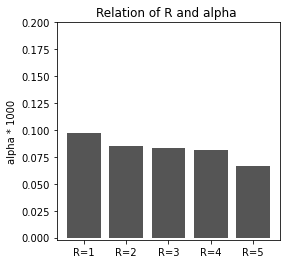

In [45]:
figure = plt.figure(figsize=(4,4))
n = [1,2,3,4,5]
plt.bar(n,alpha,color='#555555')
ax=plt.gca()
plt.ylim((-.002, 0.2))
plt.ylabel("alpha * 1000")
ax.set_xticklabels([make_xlabel_R(k) for k in range(6)])
ax.set_title("Relation of R and alpha ")